<a href="https://colab.research.google.com/github/Ishat2038/Dynamic-Hand-Gesture-Recognition-Using-3D-CNN/blob/main/Dynamic_HGR_recognition_using_3DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dynamic hand gesture recognition (HGR) using 3DCNN**

**Connect Google drive**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !ls -la /content/drive/'My Drive'

**Import libraries**

In [ ]:
# System and OS utilities
import os
import time
import math
import random
from pathlib import Path
import itertools

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Image and video processing
import cv2
import matplotlib.pyplot as plt

# TensorFlow and Keras - Core libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model

# Keras - Preprocessing and data augmentation
from keras.preprocessing.image import ImageDataGenerator

# Keras - Model architecture
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Flatten, Dense

# Keras - Training utilities
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy, CategoricalAccuracy
from keras.regularizers import l2

**Train Test folders**

In [ ]:
train_dir = '/content/drive/My Drive/Dataset/Data/Train/Train'
test_dir = '/content/drive/My Drive/Dataset/Data/Test/Test'

## **Preprocessing dataset**

**Step 1: Apply Augmentation**

In [ ]:
def apply_augmentation(frame, augmentation_choice):
    #augmentation_choice = random.choice(['flip', 'rotate', 'zoom', 'brightness', 'contrast'])

    if augmentation_choice == 'crop':
        crop_size = np.random.uniform(0.8, 1.0)  # Random cropping more aggressively
        frame = tf.image.central_crop(frame, central_fraction=crop_size)
    elif augmentation_choice == 'zoom':
        zoom_factor = np.random.uniform(1.0, 1.2)  # Random zoom factor
        h, w = frame.shape[0], frame.shape[1]
        zoomed_h, zoomed_w = int(zoom_factor * h), int(zoom_factor * w)
        frame = tf.image.resize(frame, [zoomed_h, zoomed_w])
        frame = tf.image.central_crop(frame, central_fraction=0.9)
    elif augmentation_choice == 'rotate':
        angle_deg = np.random.uniform(-15, 15)  # Random rotation between -20 to 20 degrees
        angle_rad = angle_deg * math.pi / 180
        frame = tfa.image.rotate(frame, angle_rad)
    elif augmentation_choice == 'translate':
        tx = np.random.uniform(-10, 10)  # Translate by up to 10 pixels horizontally and vertically
        ty = np.random.uniform(-10, 10)
        translations = [tx, ty]
        frame = tfa.image.translate(frame, translations)

    return frame

**Step 2: Generate batches of sequences**

In [ ]:
def load_and_process_frames(video_folder_path, target_size=(224, 224), augmentation=False):
    frame_files = sorted([os.path.join(video_folder_path, f) for f in os.listdir(video_folder_path) if f.endswith('.png')])
    processed_frames = []
    # Select only the middle frames, excluding the first 3 and last 2 frames
    middle_frames = frame_files[3:-2]
    choice = random.choice(['crop', 'rotate', 'zoom', 'translate'])
    for file in middle_frames:
    #for file in frame_files:
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        if augmentation:
            img = apply_augmentation(img, choice)
        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalizes the images
        processed_frames.append(img)
    return np.stack(processed_frames)

In [ ]:
import os
import random
import tensorflow as tf
import numpy as np

def sequence_generator(directory, class_names, batch_size=10, sequence_length=25, target_size=(224, 224), augmentation=False, mode='train'):
    def train_val_split(video_folders, split_ratio=0.75):
        split_index = int(len(video_folders) * split_ratio)
        random.shuffle(video_folders)
        return video_folders[:split_index], video_folders[split_index:]

    def generator():
            label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
            for class_name in class_names:
                class_path = os.path.join(directory, class_name)
                all_video_folders = os.listdir(class_path)
                random.shuffle(all_video_folders)  # Shuffle each time before splitting
                train_folders, val_folders = train_val_split(all_video_folders)

                folders_to_use = train_folders if mode == 'train' else val_folders

                for video_folder in folders_to_use:
                    video_folder_path = os.path.join(class_path, video_folder)
                    sequence = load_and_process_frames(video_folder_path, target_size)
                    label = label_map[class_name]
                    yield sequence, label

    output_signature = (
        tf.TensorSpec(shape=(sequence_length, *target_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


**Random shuffling video folders before splitting into Train/Test**

In [ ]:
def sequence_generator_rand(directory, class_names, batch_size=10, sequence_length=25, target_size=(224, 224), augmentation=False, mode='train'):
    def train_val_split(all_videos, split_ratio=0.75):
        split_index = int(len(all_videos) * split_ratio)
        random.shuffle(all_videos)
        return all_videos[:split_index], all_videos[split_index:]

    def generator():

            label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
            # Create a list of all (class_name, video_folder) pairs
            all_videos = [(class_name, video_folder)
                          for class_name in class_names
                          for video_folder in os.listdir(os.path.join(directory, class_name))]

            # Shuffle and split the videos
            random.shuffle(all_videos)
            train_videos, val_videos = train_val_split(all_videos)
            videos_to_use = train_videos if mode == 'train' else val_videos

            # Cycle through videos and accumulate batch
            for class_name, video_folder in itertools.cycle(videos_to_use):
                video_folder_path = os.path.join(directory, class_name, video_folder)
                sequence = load_and_process_frames(video_folder_path, target_size)
                label = label_map[class_name]
                yield sequence, label
    output_signature = (
        tf.TensorSpec(shape=(sequence_length, *target_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

**Step 3: Split into Train/Test/Validation dataset**

In [ ]:
def sequence_generator_test(directory, class_names, batch_size=10, sequence_length=25, target_size=(224, 224), augmentation=False):

    def generator():

      # while True:  # Infinite loop to keep generating data
        label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
        for class_name in class_names:
            class_path = os.path.join(directory, class_name)
            all_video_folders = os.listdir(class_path)
            for video_folder in all_video_folders:
                video_folder_path = os.path.join(class_path, video_folder)
                sequence = load_and_process_frames(video_folder_path, target_size)
                label = label_map[class_name]
                yield sequence, label
                #yield sequence, label_map(class_name)

    output_signature = (
        tf.TensorSpec(shape=(sequence_length, *target_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### **Print and visualize the shapes, labels** (optional)

In [ ]:
#without augmentation
check_dataset = sequence_generator(train_dir, class_names, batch_size=10, augmentation=False, mode='train')
#with augmentation
check_dataset_aug = sequence_generator(train_dir, class_names, batch_size=10, augmentation=True, mode='train')

In [ ]:
count_x = 0
start_time = time.time()
for batch_X, batch_y in check_dataset_aug:
    print("Shapes of batch ", count_x, "are:", batch_X.shape, batch_y)
    count_x = count_x + 1
    if count_x == 2:
        break
    #break
print("Number of batch x:", count_x)
end_time = time.time()
# Calculate and print the processing time
processing_time = end_time - start_time
print(f"Processing time: {processing_time:.4f} seconds")

Shapes of batch  0 are: (10, 25, 224, 224, 3) tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int16)
Shapes of batch  1 are: (10, 25, 224, 224, 3) tf.Tensor([0 0 0 0 0 0 0 0 1 1], shape=(10,), dtype=int16)
Number of batch x: 2
Processing time: 126.6990 seconds


**Visualize a sequence batch**

In [ ]:
import matplotlib.pyplot as plt
def visualize_sequence(sequence, label, class_names):
    num_frames = sequence.shape[0]  # Number of frames in the sequence

    # Set the width of each subplot and the height of the figure
    subplot_width = 10  # Adjust this value as needed
    fig_width = subplot_width * num_frames
    fig_height = 10  # Adjust this value as needed for the height

    #plt.figure(figsize=(fig_width, fig_height))  # Set the figure size
    for i in range(num_frames):
        plt.figure(figsize=(fig_width, fig_height))
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(sequence[i])
        plt.title(f'Frame {i+1} - {class_names[label]}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
batch_size = 10  # or your chosen batch size
dataset = sequence_generator(train_dir, class_names, batch_size=batch_size, sequence_length=25, target_size=(224, 224), augmentation=True, mode='train')

# Fetch one batch
for sequences, labels in dataset.take(1):
    # Select the first sequence and its label from the batch
    sequence_to_visualize = sequences[0].numpy()  # Convert to NumPy array if needed
    label_of_sequence = labels[0].numpy()

    # Visualize the sequence
    visualize_sequence(sequence_to_visualize, label_of_sequence, class_names)
    break  # Break after fetching one batch

**Create train test and validation generator**

Raw data

In [ ]:
train_dataset = sequence_generator(train_dir, class_names, batch_size=10, augmentation=False, mode='train')
val_dataset = sequence_generator(train_dir, class_names, batch_size=10, augmentation=False, mode='validation')
test_dataset = sequence_generator_test(test_dir, class_names, batch_size=10, augmentation=False)

Augmented data

In [ ]:
train_dataset_aug = sequence_generator(train_dir, class_names, batch_size=10, augmentation=True, mode='train')
val_dataset_aug = sequence_generator(train_dir, class_names, batch_size=10, augmentation=True, mode='validation')

# **Training the 3DCNN model**

**CNN Model**

In [ ]:
img_height, img_width = 224, 224
num_frames_per_sequence = 25
batch_size = 10
num_classes = len(class_names)

# Define the 3D CNN model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Flatten, Dense
from keras.regularizers import l2

model_cnn = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001),
           input_shape=(num_frames_per_sequence, img_height, img_width, 3)),
    MaxPooling3D((2, 2, 2), strides=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    Conv3D(64, (3, 3, 3), activation='relu', dilation_rate=(1, 1, 1), padding='same',
           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    MaxPooling3D((2, 2, 2), strides=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    #second layer
    Conv3D(128, (3, 3, 3), activation='relu', dilation_rate=(1, 1, 1), padding='same',
           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    MaxPooling3D((2, 2, 2), strides=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    #fourth layer
    Conv3D(256, (3, 3, 3), activation='relu', dilation_rate=(1, 1, 1), padding='same',
           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    MaxPooling3D((2, 2, 2), strides=(2, 2, 2)),
    BatchNormalization(),
    Dropout(0.40),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Correct activation for multi-class classification
])


**Compile**

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_cnn.compile(
    optimizer=optimizer,  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### **Visualize 3DCNN model structure**(optional)

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 25, 224, 224, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 12, 112, 112, 32   0         
 g3D)                        )                                   
                                                                 
 batch_normalization_4 (Bat  (None, 12, 112, 112, 32   128       
 chNormalization)            )                                   
                                                                 
 dropout_4 (Dropout)         (None, 12, 112, 112, 32   0         
                             )                                   
                                                                 
 conv3d_5 (Conv3D)           (None, 12, 112, 112, 64  

**Loading previously trained and saved model**

In [ ]:
model_path = '/content/drive/MyDrive/Dataset/code/best_model_25f_without_aug.keras'
if os.path.exists(model_path):
  model = load_model(model_path)
  print("Model loaded successfully!")
  # Proceed with using the loaded model
else:
  print("Error: Model file not found at", model_path)
model.trainable = True

Model loaded successfully!


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Train dataset**

In [ ]:
#train_dataset_aug, val_dataset_aug, train_dataset_rand, val_dataset_rand
history = model.fit(
    train_dataset_aug,  # Replace with your training dataset
    epochs=20,  # Adjust number of epochs as needed
    validation_data=val_dataset_aug,  # Replace with your validation dataset
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Dataset/code/cnn_25f_aug.keras', monitor='val_loss', save_best_only=True, mode='min')
    ]
)



Epoch 1/20
20/20 [==============================] - 34s 2s/step - loss: 0.3083 - accuracy: 0.9949 - val_loss: 0.3602 - val_accuracy: 0.9848 - lr: 9.9357e-05
Epoch 2/20
20/20 [==============================] - 34s 2s/step - loss: 0.2747 - accuracy: 1.0000 - val_loss: 0.3558 - val_accuracy: 0.9697 - lr: 9.9337e-05
Epoch 3/20
20/20 [==============================] - 35s 2s/step - loss: 0.2718 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.9848 - lr: 9.9316e-05
Epoch 4/20
20/20 [==============================] - 35s 2s/step - loss: 0.2707 - accuracy: 1.0000 - val_loss: 0.2954 - val_accuracy: 0.9848 - lr: 9.9296e-05
Epoch 5/20
20/20 [==============================] - 35s 2s/step - loss: 0.2697 - accuracy: 1.0000 - val_loss: 0.2741 - val_accuracy: 1.0000 - lr: 9.9275e-05
Epoch 6/20
20/20 [==============================] - 33s 2s/step - loss: 0.2689 - accuracy: 1.0000 - val_loss: 0.2764 - val_accuracy: 1.0000 - lr: 9.9254e-05
Epoch 7/20
20/20 [==============================] - 33s 2s

# **Visualize results**

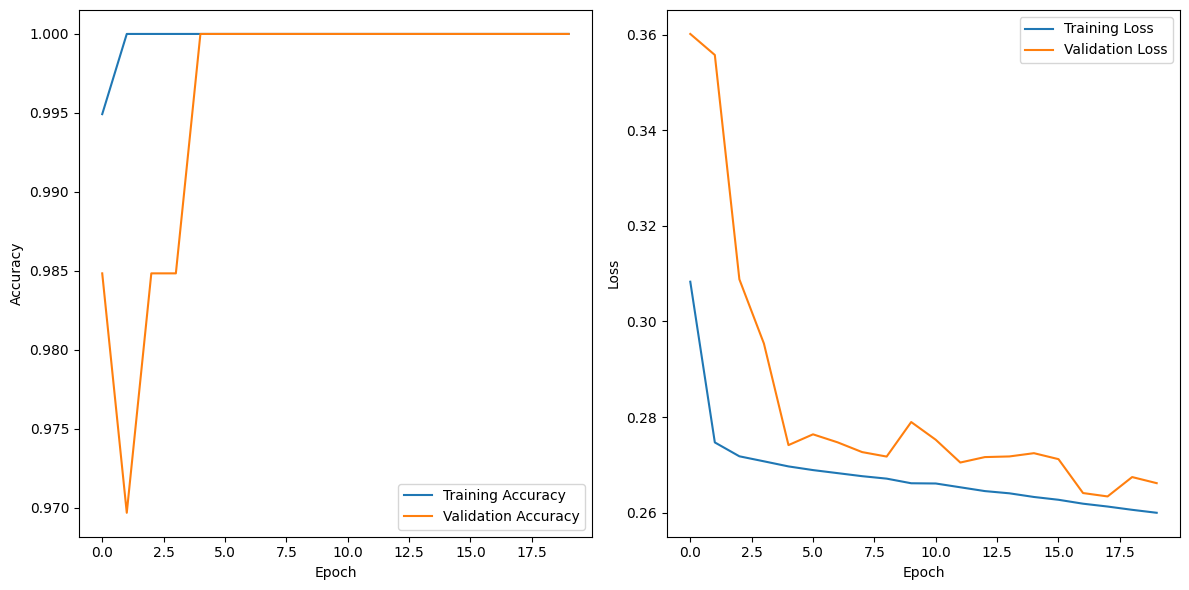

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **prediction accuracy**

In [ ]:
result = model.evaluate(test_dataset, return_dict=True)

27/27 [==============================] - 31s 1s/step - loss: 0.2644 - accuracy: 1.0000


In [ ]:
test_dataset_aug = sequence_generator_test(test_dir, class_names, batch_size=10, augmentation=True)

In [ ]:
result_1 = model.evaluate(test_dataset_aug, return_dict=True)

27/27 [==============================] - 31s 1s/step - loss: 0.2644 - accuracy: 1.0000


In [ ]:
final_loss, final_accuracy = model.evaluate(val_dataset)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

7/7 [==============================] - 10s 1s/step - loss: 0.2633 - accuracy: 1.0000
Final loss: 0.26
Final accuracy: 100.00%


In [ ]:
final_loss, final_accuracy = model_cnn.evaluate(test_dataset)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

27/27 [==============================] - 31s 1s/step - loss: 0.3012 - accuracy: 1.0000
Final loss: 0.30
Final accuracy: 100.00%


In [ ]:
# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)
from keras.metrics import Precision, Recall, BinaryAccuracy
import matplotlib.font_manager as font_manager
from sklearn.metrics import classification_report

### **Prediction labels**

In [ ]:
def get_predictions_and_labels(dataset):
    all_predictions = []
    all_labels = []

    for batch, labels in dataset:
        # Generate predictions
        predictions = model.predict(batch)
        # Convert predictions to class indices
        predicted_classes = np.argmax(predictions, axis=1)
        all_predictions.extend(predicted_classes)
        all_labels.extend(labels.numpy())

    return np.array(all_predictions), np.array(all_labels)

# Get predictions and labels for both training and testing sets
train_dataset_1 = sequence_generator_test(train_dir, class_names, batch_size=10, augmentation=True)
print("Train predictions and labels:")
train_predictions, train_labels = get_predictions_and_labels(train_dataset_1)
print("Test predictions and labels:")
test_predictions, test_labels = get_predictions_and_labels(test_dataset)


Train predictions and labels:
1/1 [==============================] - 0s 59ms/step
Test predictions and labels:
1/1 [==============================] - 0s 59ms/step


### **precision, recall, f1 score, and support**

In [ ]:
from sklearn.metrics import classification_report

def get_classification_report(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names)
    return report

# Get classification report for the test dataset
target_names = [str(cls) for cls in class_names]  # Assuming class_names is a list of class names
print(get_classification_report(test_labels, test_predictions, target_names))


              precision    recall  f1-score   support

         aat       1.00      1.00      1.00        24
        char       1.00      1.00      1.00        24
        choy       1.00      1.00      1.00        24
         dos       1.00      1.00      1.00        24
         dui       1.00      1.00      1.00        23
          ek       1.00      1.00      1.00        24
         noy       1.00      1.00      1.00        24
        pach       1.00      1.00      1.00        24
        saat       1.00      1.00      1.00        24
      shunno       1.00      1.00      1.00        24
         tin       1.00      1.00      1.00        24

    accuracy                           1.00       263
   macro avg       1.00      1.00      1.00       263
weighted avg       1.00      1.00      1.00       263



### **Confusion matrix**

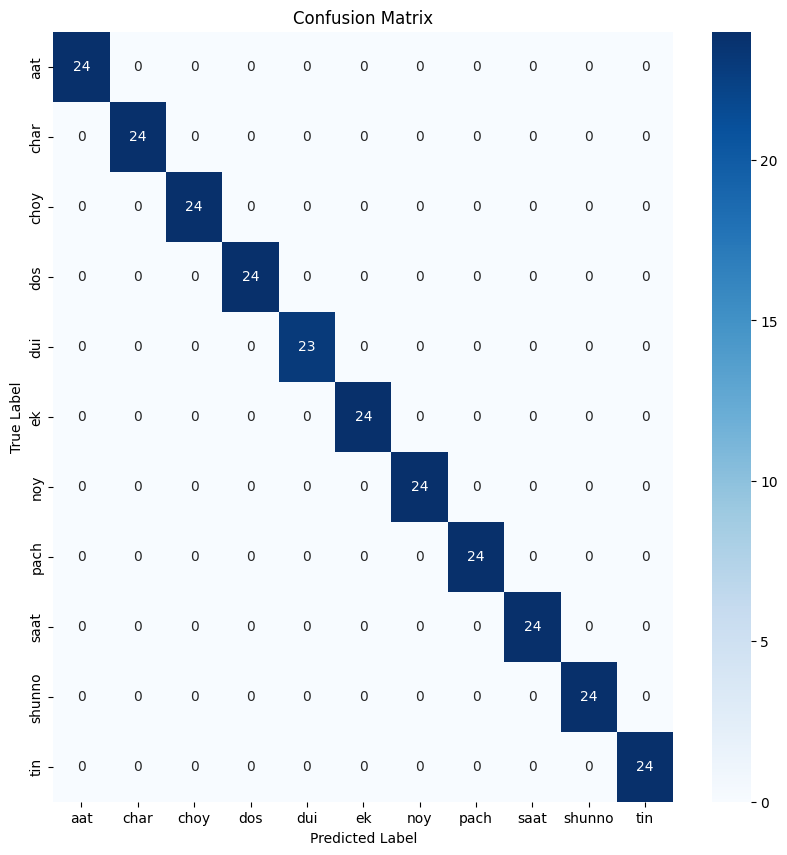

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrix for the test dataset
plot_confusion_matrix(test_labels, test_predictions, class_names)
